# `pandas.DataFrame` based dataset


This tutorial covers how to use GluonTS's pandas DataFrame based dataset
`PandasDataset`. After going through a few common use cases we explain in
detail what data formats `PandasDataset` can work with, how to include
static and dynamic features and how to do train/test splits.


## Introduction

`PandasDataset` is meant to work on `pandas.DataFrame`, `pandas.Series` and
any collection of both.
The minimal requirement to start modelling using GluonTS's dataframe dataset
is a list of monotonically increasing timestamps with a fixed frequency
and a list of corresponding target values in `pandas.DataFrame`:

|timestamp|target|
|----|----|
|2021-01-01 00:00:00|-0.21|
|2021-01-01 01:00:00|-0.33|
|2021-01-01 02:00:00|-0.33|
|...|...|

If you have additional dynamic or static features, you can include those
in separate columns as following:

|timestamp|target|stat_cat_1|dyn_real_1|
|----|----|----|----|
|2021-01-01 00:00:00|-0.21|0|0.79|
|2021-01-01 01:00:00|-0.33|0|0.59|
|2021-01-01 02:00:00|-0.33|0|0.39|
|...|...|...|...|

GluonTS also supports multiple time series.
Those can either be a list of the DataFrames with the format above
(having at least a `timestamp` index or column and `target` column),
a dict of DataFrames or a Long-DataFrame that has an additional
`item_id` column that groups the different time series.
When using a dict, the keys are used as `item_id`s. An example with
two time series including static and dynamic feature is the following:

|timestamp|target|item_id|stat_cat_1|dyn_real_1|
|----|----|----|----|----|
|2021-01-01 00:00:00|-0.21|A|0|0.79|
|2021-01-01 01:00:00|-0.33|A|0|0.59|
|2021-01-01 02:00:00|-0.33|A|0|0.39|
|2021-01-01 01:00:00|-1.24|B|1|-0.60|
|2021-01-01 02:00:00|-1.37|B|1|-0.91|

Here, the time series values are represented by the `target` column with
corresponding timestamp values in the `timestamp` column. Another necessary column
is the `item_id` column that indicates which time series a specific row belongs to.
In this example, we have two time series, one indicated by item `A` and the other
by `B`. In addition, if we have other features we can include those too
(`stat_cat_1` and `dyn_real_1` in the example above).


## Use case 1 - Loading data from a `long` dataframe

In the first use case we are given multiple time series stacked on top
of each other in a dataframe with an `item_id` column that distinguishes
different series.

In [1]:
import pandas as pd

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
df.head()

,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A


After reading the data into a `pandas.DataFrame` we can easily convert
it to `gluonts.dataset.pandas.PandasDataset` and train an estimator an get forecasts.

In [2]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

In [3]:
from gluonts.mx import DeepAREstimator, Trainer

estimator = DeepAREstimator(
    freq=ds.freq, prediction_length=24, trainer=Trainer(epochs=1)
)
predictor = estimator.train(ds)
predictions = predictor.predict(ds)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 14.52it/s, epoch=1/1, avg_epoch_loss=0.656]

## Use case 2 - Loading data with missing values

In case the `timestamp` column is not evenly spaced and monotonically increasing
we get an error when using `PandasDataset`. Here we show how to fill in the gaps
that are missing.

Let's first remove some random rows from the `long` dataset.

In [4]:
import pandas as pd
import numpy as np

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
remove_ind = np.random.choice(np.arange(df.shape[0]), size=100, replace=False)
mask = [False if i in remove_ind else True for i in range(df.shape[0])]
df_missing_val = df.loc[mask, :]  # dataframe with 100 rows removed from df

Now, we group by the `item_id` and reindex each of the grouped dataframes.
Reindexing, as it is done below, will add new rows with `NaN` values where
the data is missing. The user can then use the `fillna()` method on each
dataframe to fill in desired value.

In [5]:
from gluonts.dataset.pandas import PandasDataset

max_end = max(df.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in df_missing_val.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1H")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)

ds = PandasDataset(dfs_dict, target="target")

## Use case 3 - Loading data from a `wide` dataframe

Here, we are given data in the `wide` format, where time series are stacked side-by-side in a `DataFrame`.
We can simply turn this into a dictionary of `Series` objects with `dict`, and construct a `PandasDataset` with it:

In [6]:
import pandas as pd

url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df_wide = pd.read_csv(url_wide, index_col=0, parse_dates=True)
print(df_wide.head())

                          A       B       C       D       E       F       G  \
2021-01-01 00:00:00 -1.3378  0.1268 -0.3645 -1.0864 -2.3803 -0.2447  2.2647   
2021-01-01 01:00:00 -1.6111  0.0926 -0.1364 -1.1613 -2.1421 -0.3477  2.4262   
2021-01-01 02:00:00 -1.9259 -0.1420  0.1063 -1.0405 -2.1426 -0.3271  2.4434   
2021-01-01 03:00:00 -1.9184 -0.4930  0.6269 -0.8531 -1.7060 -0.3088  2.4307   
2021-01-01 04:00:00 -1.9168 -0.5057  0.9419 -0.7666 -1.4287 -0.4284  2.3258   

                          H       I       J  
2021-01-01 00:00:00 -0.7917  0.7071  1.3763  
2021-01-01 01:00:00 -0.9609  0.6413  1.2750  
2021-01-01 02:00:00 -0.9034  0.4323  0.6767  
2021-01-01 03:00:00 -0.9602  0.3193  0.5150  
2021-01-01 04:00:00 -1.2504  0.3660  0.1708  


In [7]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset(dict(df_wide))

As shown in `Use case 1` we can now use `ds` to train an estimator.


## General use cases

Here, we explain in detail what data formats `PandasDataset` can work with,
how to include static and dynamic features and how to do train/test splits.

### Dummy data generation

Let's create a function that generates dummy time series conforming above
stated requirements (`timestamp` index and `target` column).
The function randomly samples sin/cos curves and outputs their sum. You don't need
to understand how this really works. We will just call `generate_single_ts`
with datetime values which rise monotonically with fixed frequency and get
a `pandas.DataFrame` with `timestamp` and `target` values.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def generate_single_ts(date_range, item_id=None) -> pd.DataFrame:
    """create sum of `n_f` sin/cos curves with random scale and phase."""
    n_f = 2
    period = np.array([24 / (i + 1) for i in range(n_f)]).reshape(1, n_f)
    scale = np.random.normal(1, 0.3, size=(1, n_f))
    phase = 2 * np.pi * np.random.uniform(size=(1, n_f))
    periodic_f = lambda x: scale * np.sin(np.pi * x / period + phase)

    t = np.arange(0, len(date_range)).reshape(-1, 1)
    target = periodic_f(t).sum(axis=1) + np.random.normal(0, 0.1, size=len(t))
    ts = pd.DataFrame({"target": target}, index=date_range)
    if item_id is not None:
        ts["item_id"] = item_id
    return ts

ts.shape: (240, 1)
                       target
2021-01-01 00:00:00 -1.175310
2021-01-01 01:00:00 -1.152185
2021-01-01 02:00:00 -1.216568
2021-01-01 03:00:00 -1.150387
2021-01-01 04:00:00 -1.247621


<Axes: >

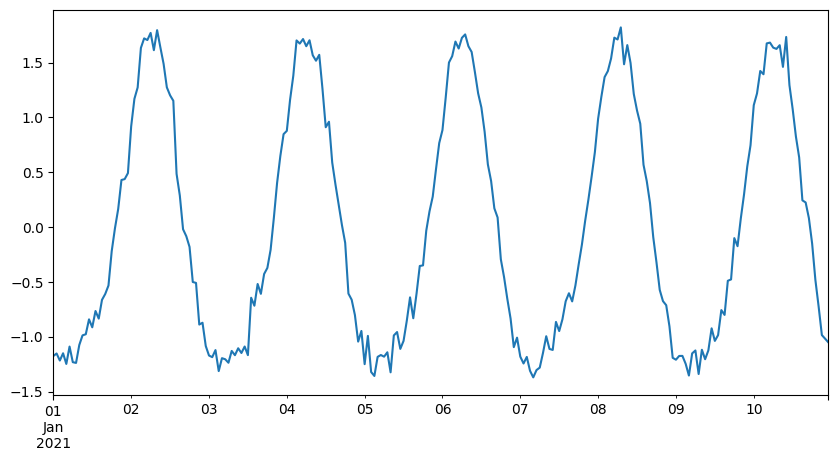

In [9]:
prediction_length, freq = 24, "1H"
T = 10 * prediction_length
date_range = pd.date_range("2021-01-01", periods=T, freq=freq)
ts = generate_single_ts(date_range)

print("ts.shape:", ts.shape)
print(ts.head())
ts.loc[:, "target"].plot(figsize=(10, 5))

### Use single time series for training

Now, we create a GluonTS dataset using the time series we generated and train
a model. Because we will use the train/evaluation loop multiple times, let's
create a function for it. The input to the function will be the time series
in multiple formats and an estimator.
The output is the `MSE` (mean squared error). In this
function we train an estimator to get the predictor, use the predictor
to create forecasts and return a metric. We also create an DeepAREstimator.
Note we run the training for just 1 epoch. Usually you need more epochs
to fully train the model.

In [10]:
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator


def train_and_predict(dataset, estimator):
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor
    )
    evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(dataset))
    return agg_metrics["MSE"]


estimator = DeepAREstimator(
    freq=freq, prediction_length=prediction_length, trainer=Trainer(epochs=1)
)

We are ready to convert the `ts` dataframe into GluonTS dataset and train
a model. For that, we import the `PandasDataset` and create an instance
using our time series `ts`. If the `target`-column is called "target"
we don't really need to provide it to the constructor. Also `freq` is
inferred from the data if the timestamp is a time- or period range.
However, in this tutorial we will be specific on 
how to use those in general.

In [11]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset(ts, target="target", freq=freq)
train_and_predict(ds, estimator)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.02it/s, epoch=1/1, avg_epoch_loss=0.539]

Running evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

0.023472231979132386

### Use multiple time series for training

As described above, we can also use a list of single time series
dataframes. Even dict of dataframes or a single long-formatted-dataframe
with multiple time series can be used and is described below.
So, let's create multiple time series and train the model
using those.

In [12]:
N = 10
multiple_ts = [generate_single_ts(date_range) for i in range(N)]

ds = PandasDataset(multiple_ts, target="target", freq=freq)
train_and_predict(ds, estimator)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.26it/s, epoch=1/1, avg_epoch_loss=0.91]

Running evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 36.63it/s]

0.046774466353901624

If the dataset is given as a long-dataframe, we can also use an
alternative constructor `from_long_dataframe`. Note in this case
we have to provide the `item_id` as well.

In [13]:
ts_in_long_format = pd.concat(
    [generate_single_ts(date_range, item_id=i) for i in range(N)]
)

# Note we need an item_id column now and provide its name to the constructor.
# Otherwise, there is no way to distinguish different time series.
ds = PandasDataset.from_long_dataframe(
    ts_in_long_format, item_id="item_id", target="target", freq=freq
)
train_and_predict(ds, estimator)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 14.88it/s, epoch=1/1, avg_epoch_loss=0.742]

Running evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 36.01it/s]

0.09143225550221631

### Include static and dynamic features

The PandasDataset also allows us to include features of our time series.
The list of all available features is given in the documentation.
Here, we use dynamic real and static categorical features.
To mimic those features we will just wrap our fancy data generator
`generate_single_ts` and add a static cat and two dynamic real features.

In [14]:
def generate_single_ts_with_features(date_range, item_id) -> pd.DataFrame:
    ts = generate_single_ts(date_range, item_id)
    T = ts.shape[0]
    # static features are constant for each series
    ts["dynamic_real_1"] = np.random.normal(size=T)
    ts["dynamic_real_2"] = np.random.normal(size=T)
    # ... we can have as many static or dynamic features as we like
    return ts


ts = generate_single_ts_with_features(date_range, item_id=0)
ts.head()

,target,item_id,dynamic_real_1,dynamic_real_2
2021-01-01 00:00:00,-0.822858,0,0.212849,-0.313528
2021-01-01 01:00:00,-0.932843,0,-0.347438,0.690760
2021-01-01 02:00:00,-1.415959,0,-0.498104,-1.432175
2021-01-01 03:00:00,-1.471930,0,0.499352,0.426574
2021-01-01 04:00:00,-1.196347,0,0.242846,0.378769


Now, when we create the GluonTS dataset, we need to let the constructor
know which columns are the categorical and real features. Also, we need a
minor modification to the `estimator`. We need to
let the `estimator` know as well that more features are coming in. Note, if
categorical features are provided, `DeepAR` also needs the cardinality as input.
We have one static categorical feature that can take on two
values (0 or 1). The cardinality in this case is a list of one element `[2,]`.

In [15]:
estimator_with_features = DeepAREstimator(
    freq=ds.freq,
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    use_feat_static_real=True,
    use_feat_static_cat=True,
    cardinality=[
        3,
    ],
    trainer=Trainer(epochs=1),
)

Let's now generate multiple time series, both as a dictionary of data frames,
and as a single long data frame. We also generate a dedicated data frame of
static features.
Note we don't provide `freq` and `timestamp`, because they are automatically
inferred from the time index. We are also not passing the `target` argument, since
it's default value is "target", which is the target column in our dataframes.

In [16]:
multiple_ts = {
    i: generate_single_ts_with_features(date_range, item_id=i) for i in range(N)
}
static_features = pd.DataFrame(
    {
        "color": pd.Categorical(np.random.choice(["red", "green", "blue"], size=N)),
        "height": np.random.normal(loc=100, scale=15, size=N),
    },
    index=list(multiple_ts.keys()),
)
multiple_ts_long = pd.concat(multiple_ts.values())

multiple_ts_dataset = PandasDataset(
    multiple_ts,
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    static_features=static_features,
)
# for long-dataset we use a different constructor and need a `item_id` column
multiple_ts_long_dataset = PandasDataset.from_long_dataframe(
    multiple_ts_long,
    item_id="item_id",
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    static_features=static_features,
)

That's it! We can now call `train_and_predict` with all
the datasets.

In [17]:
train_and_predict(multiple_ts_dataset, estimator_with_features)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 12.07it/s, epoch=1/1, avg_epoch_loss=1.4]

Running evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 37.14it/s]

0.25145185006648246

In [18]:
train_and_predict(multiple_ts_long_dataset, estimator_with_features)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 12.19it/s, epoch=1/1, avg_epoch_loss=1.48]

Running evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 37.20it/s]

0.3680281639680776

### Use train/test split

Here, we split the DataFrame/DataFrames into training and test data.
We can then
use the training data to train the model and the test data for prediction.
For training we will use the entire dataset up to last `prediction_length`
entries. For testing we feed the entire dataset into
`make_evaluation_predictions`, which automatically splits the last
`prediction_length` entries for us and returns their predictions.
Then, we forward those predictions to the `Evaluator`, which calculates
a bunch of metrics for us
(including `MSE`, `RMSE`, `MAPE`, `sMAPE`, ...).

In [19]:
train = PandasDataset(
    {item_id: df[:-prediction_length] for item_id, df in multiple_ts.items()},
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    static_features=static_features,
)

test = PandasDataset(
    multiple_ts,
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    static_features=static_features,
)

In [20]:
predictor = estimator_with_features.train(train)
forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor)
evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(test))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 11.58it/s, epoch=1/1, avg_epoch_loss=1.28]

Running evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 36.55it/s]

### Train and visualize forecasts

Let's generate 100 time series dataframes, create a train/test split,
train an estimator and visualize the forecasts.

In [21]:
prediction_length, freq = 24, "1H"
T = 10 * prediction_length
date_range = pd.date_range("2021-01-01", periods=T, freq=freq)

N = 100
time_seriess = [generate_single_ts(date_range, item_id=i) for i in range(N)]

train = PandasDataset([ts.iloc[:-prediction_length, :] for ts in time_seriess])
test = PandasDataset(time_seriess)

In [22]:
estimator = DeepAREstimator(
    freq=freq,
    prediction_length=prediction_length,
    trainer=Trainer(epochs=10),
)
predictor = estimator.train(train)
forecast_it, ts_it = make_evaluation_predictions(dataset=test, predictor=predictor)
forecasts = list(forecast_it)
tests = list(ts_it)
evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
agg_metrics, item_metrics = evaluator(tests, forecasts, num_series=len(test))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 14.84it/s, epoch=1/10, avg_epoch_loss=0.621]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.42it/s, epoch=2/10, avg_epoch_loss=-0.309]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.52it/s, epoch=3/10, avg_epoch_loss=-0.417]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 14.90it/s, epoch=4/10, avg_epoch_loss=-0.475]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.25it/s, epoch=5/10, avg_epoch_loss=-0.503]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.48it/s, epoch=6/10, avg_epoch_loss=-0.532]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.48it/s, epoch=7/10, avg_epoch_loss=-0.558]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.34it/s, epoch=8/10, avg_epoch_loss=-0.57]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.34it/s, epoch=9/10, avg_epoch_loss=-0.591]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.70it/s, epoch=10/10, avg_epoch_loss=-0.592]

Running evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 1964.53it/s]

Let's plot a few randomly chosen series.

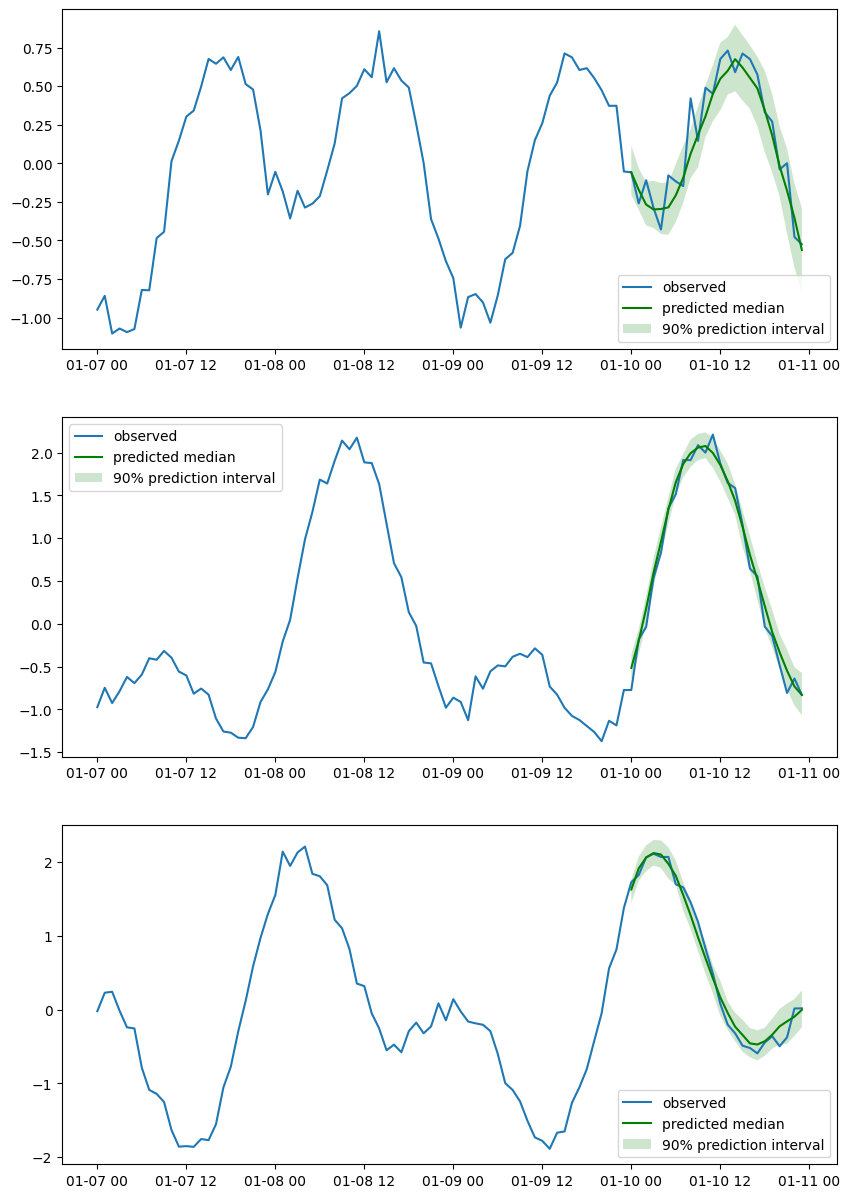

In [23]:
n_plot = 3
indices = np.random.choice(np.arange(0, N), size=n_plot, replace=False)
fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))
for index, ax in zip(indices, axes):
    ax.plot(tests[index][-4 * prediction_length :].to_timestamp())
    plt.sca(ax)
    forecasts[index].plot(intervals=(0.9,), color="g")
    plt.legend(["observed", "predicted median", "90% prediction interval"])